In [8]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

In [9]:
geodata = pd.read_csv('CommunityClubsTest-clean.csv')
print(geodata)
bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
print(bloodbankcoords)
privhospcoords = pd.read_csv("Plot of Hospitals, Blood Banks & Community Centers- Private Hospital Plot.csv")
pubhospcoords = pd.read_csv("Plot of Hospitals, Blood Banks & Community Centers- Public Hospital Plot.csv")

            Y           X     Name
0    1.427493  103.792241    kml_1
1    1.354658  103.889546    kml_2
2    1.397128  103.886666    kml_3
3    1.366833  103.840668    kml_4
4    1.320799  103.747540    kml_5
..        ...         ...      ...
120  1.339973  103.737066  kml_121
121  1.386807  103.771521  kml_122
122  1.341263  103.933010  kml_123
123  1.311728  103.952223  kml_124
124  1.339360  103.727300  kml_125

[125 rows x 3 columns]
       Blood Bank  Postal Code  Latitude   Longitude
0             HSA       169078  1.281335  103.838482
1     Dhoby Ghaut       238826  1.299755  103.846084
2  Westgate Tower       608531  1.335374  103.743005
3       Woodlands       730900  1.436139  103.787195
4     One Punggol       828629  1.408468  103.905039


FileNotFoundError: [Errno 2] No such file or directory: 'Plot of Hospitals, Blood Banks & Community Centers- Private Hospital Plot.csv'

In [ ]:
# y-coordinates/latitude of CCs, BBs and hospitals
y_coordCC = geodata['Y']
y_coordBB = bloodbankcoords['Latitude']
y_coord_privhosp = privhospcoords['Latitude']
y_coord_pubhosp = pubhospcoords['Latitude']

# x-coordinates/longitude of CCs, BBs and hospitals
x_coordCC = geodata['X']
x_coordBB = bloodbankcoords['Longitude']
x_coord_privhosp = privhospcoords['Longitude']
x_coord_pubhosp = pubhospcoords['Longitude']


#no. of BBs
nbrblood = 5

#no. of CCs
nbrcomm = 125

#no. of private hosps
nbrprivh = 9

#no. of public hosps
nbrpubh = 10

#radius of earth
R = 6371


def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# distance calculations between CC and BBs
distancelct=np.empty([nbrblood, nbrcomm])
for i_index in range(nbrblood):
    for j_index in range(nbrcomm):
        d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
        d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
        a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distancelct[i_index,j_index] = R*c

# print(distancelct)

# Distance calculation between BBs and private hospitals
distanceBB_priv = np.empty((nbrblood, nbrprivh))

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrprivh):  # loop over private hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_privhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_privhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_privhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_priv[i_index, h_index] = R * c


distanceBB_pub = np.empty((nbrblood, nbrpubh))

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrpubh):  # loop over public hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_pubhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_pubhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_pubhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_pub[i_index, h_index] = R * c


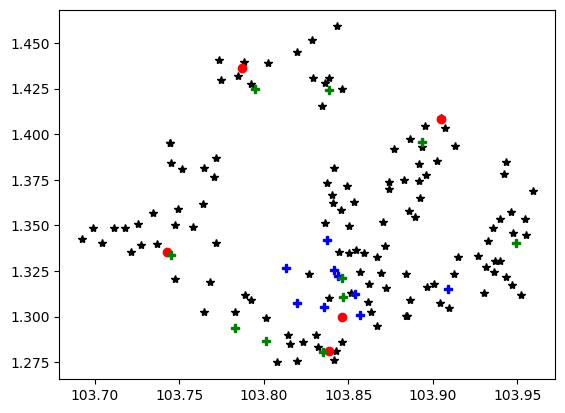

In [ ]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green')

In [ ]:
# Initialize empty solutions to populate from each iteration of epsilon-constraint method 
optimal_costs = []
optimal_distances = []
detailed_solutions = []


 #Create Model
model = gp.Model("P_Median_Epsilon_Constraint_Style")

I = list(range(nbrblood)) #Open Facilities  
J = list(range(nbrcomm)) #Facilities to be served
H_priv = list(range(nbrprivh))                          
H_pub = list(range(nbrprivh, nbrprivh + nbrpubh))        
H = H_priv + H_pub                                       

 # Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open
z = model.addVars(I, H, vtype=GRB.BINARY, name="deliver") # Deliver from blood banks to hospitals

 # Define objective functions
model.setObjective(
    gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J) +
    gp.quicksum(z[i, h] * distanceBB_priv[i][h] for i in I for h in H_priv) +
    gp.quicksum(z[i, h] * distanceBB_pub[i][h - nbrprivh] for i in I for h in H_pub),
    GRB.MINIMIZE
)
 # Minimize total distance from demands to the nearest open facilities
 # Each demand location j must be assigned to exactly one facility i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")
 # The demand from location i can only be assigned to an open facility j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")

q_c = pd.read_csv('community_centres_with_blood_collection.csv')['Amount of Blood Collected']    # Change this
g_b = [50, 60, 70, 65, 55]                # Min blood required at each bank
q_b = [100, 120, 130, 110, 115]            # Max capacity at each bank

model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) >= 0.9*328, name="lower_bound_sum")

model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 328*1.1, name="upper_bound_sum")

model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank


f_bc = 0.094*2.61
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 1000, name="budget_constraint")

model.optimize()

# Check if a solution was found
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimal objective value: {model.objVal}")

    # Print values of decision variables
    for var in model.getVars():
        if var.X > 1e-6:  # print only non-zero values
            print(f"{var.VarName} = {var.X}")
else:
    print("No optimal solution found.")


Set parameter Username
Set parameter LicenseID to value 2668971
Academic license - for non-commercial use only - expires 2026-05-21


NameError: name 'nbrblood' is not defined

AttributeError: Unable to retrieve attribute 'X'

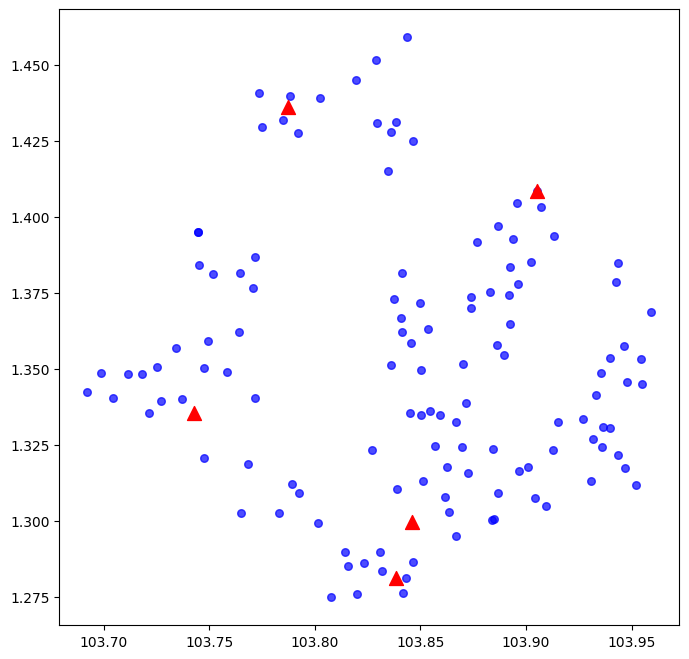

In [ ]:

# Assume you have:
# df_comm: DataFrame with columns ['Y','X','Name'] for community centres
# df_bank: DataFrame with ['Latitude','Longitude','Blood Bank'] for blood banks

# Extract coordinates
comm_coords = geodata[['X','Y']].values
bank_coords = bloodbankcoords[['Longitude','Latitude']].values

# Plot nodes
plt.figure(figsize=(8, 8))
plt.scatter(comm_coords[:,0], comm_coords[:,1], c='blue', label='Community Centres', s=30, alpha=0.7)
plt.scatter(bank_coords[:,0], bank_coords[:,1], c='red', label='Blood Banks', s=100, marker='^')

# Draw assignment lines

# ...existing code...

plt.figure(figsize=(8, 8))
plt.scatter(comm_coords[:,0], comm_coords[:,1], c='blue', label='Community Centres', s=30, alpha=0.7)
plt.scatter(bank_coords[:,0], bank_coords[:,1], c='red', label='Blood Banks', s=100, marker='^')

plt.legend()  # Call legend here, after scatter plots

# Draw assignment lines
x_vals = {(i, j): x[i, j].X for i in I for j in J}

for i in I:
    for j in J:
        if x_vals[i, j] > 0.5:
            bx, by = bank_coords[i]
            cx, cy = comm_coords[j]
            plt.plot([bx, cx], [by, cy], c='gray', linewidth=0.7)

plt.title("Optimal Assignments: Community Centres → Blood Banks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
